## Sinewave synthesis of speech

This notebook presents and shows how to use a speech synthesizer that converts formant trajectories into time-varying sinusoidal waves - **sinewave speech**.  See for example Remez et al. (1981).

The function sine_synth() requires a pandas dataframe with speech analysis data in these columns:
  
- sec: Time (seconds) of the frames. The assumption is that these are equally spaced.
- rms:  The RMS amplitude of each frame.
- f1,f2,f3,f4:  Frequencies (Hz) of the lowest four vowel formants, in the frames. 
   
In our implementation these are produced by the program "ifc_formant" as a tab separated text file.
    
The overall amplitude contour of the sine wave speech waveform is determined by the RMS contour in the input file. The frequencies of four sine wave components are given by the formant estimates in the input file.

The amplitude of the sine wave speech waveform is scaled to use the full amplitude range available with 16 bit integer samples.

This is a python translation of code that Keith Johnson got from Howard Nusbaum, via Alexander Francis, in 1998.


------------
Remez, R. E.; Rubin, P. E.; Pisoni, D. B.; Carrell, T. D. (1981). "Speech perception without traditional speech cues". Science. 212 (4497): 947–950. doi:10.1126/science.7233191.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io.wavfile import write

from sgram import sgram  # /https://github.com/keithjohnson-berkeley/sgram.git
                        # pip install .

from IPython.display import Audio

In [2]:
def sine_synth(formant_data,fs=16000):
    '''
    sine_synth() produces 'sinewave speech' - an audio file made up of time-varying 
    sinusoidal waves at the frequencies of the vowel formants.
    
    Inputs:
       formant_data:  a pandas dataframe with speech analysis data in these columns:
          - sec: Time (seconds) of the frames. The assumption is that these are equally spaced.
          - rms:  The RMS amplitude of each frame.
          - f1,f2,f3,f4:  Frequencies (Hz) of the lowest four vowel formants, in the frames. 
       fs(default=16000):  the sampling frequency of the resulting sound wave.
       
    Outputs:
        wav: a one-dimensional numpy array containing audio samples
        fs: the sampling frequency of the audio samples in wav
    '''
    pifac = np.pi*2/fs
    
    step=formant_data.sec[1]-formant_data.sec[0]  # read step size from input
    nframes = len(formant_data)  # read file length from input
    npoints = int(np.round(step*fs))
    
    wav = np.zeros(npoints*nframes)  # allocate a waveform buffer
    
    rms = formant_data.rms
    formants = np.array((formant_data.f1,
                         formant_data.f2, 
                         formant_data.f3,
                         formant_data.f4))
    
    # TODO:  check that formant frequencies do not exceed fs/2
    #         if they do, consider increasing fs
        
    for f in range(formants.shape[0]):   # synthesize each formant
        rfreq = 0.0
        iwv = 0
        for y in range(1,nframes):      # synthesize frame by frame
            amp = rms[y-1]
            freq = formants[f,y-1]*pifac
            ainc = (rms[y]-rms[y-1])/npoints
            finc = ((formants[f,y]-formants[f,y-1])*pifac)/npoints
            
            for i in range(npoints):    # synthesize each point in the frame
                rfreq += freq
                #if (rfreq > 2*np.pi):  # is this "if" really necessary?
                #    rfreq -= 2*np.pi
                wav[iwv] += np.sin(rfreq)*amp
                amp += ainc
                freq += finc
                iwv += 1
    
    # add rise time and decay time
    ns = int(0.02 * fs)  # number of samples in 20ms
    fac = 0
    facinc = 1.0/ns
    for x in range(ns):   
        wav[x] *= fac    # apply a short (20ms) rise time
        wav[-x] *= fac  # and a short (20ms) decay time
        fac += facinc
    
    # scale to integer range
    wav *= np.iinfo(np.int16).max / np.max(np.abs(wav))
           
    return wav,fs 

## read pandas dataframe

The file we are reading here was produced by "ifc_formant", an implementation of 
Watenabe\'s Inverse Filter Control method of formant tracking.

- It would be good to show how to use parselmouth to get the formants.
- Or wrap ifc_formant for python distribution

Watanabe, A. (2001). Formant estimation method using inverse-filter control. IEEE Transactions on Speech and Audio Processing, 9, 317-326.

In [3]:
formant_data = pd.read_csv('toe_AP.fb',sep='\t')
formant_data.head()

,sec,rms,f1,f2,f3,f4,f0
0,0.005,1.8,1017.7,2001.4,3063.2,4380.0,0.0
1,0.015,1.8,1033.6,2102.7,3084.6,4309.2,0.0
2,0.025,1.9,792.2,2234.5,3297.1,4325.1,0.0
3,0.035,1.9,684.5,2162.0,3397.5,4283.1,63.5
4,0.045,1.8,611.0,2054.6,3213.5,4180.0,0.0


## Do the Synthesis

Here we do the synthesis, write it to a wav file, and use sgram() to display a spectrogram of it, and Audio() to listen to it.

Resampling from 16000 to 10000


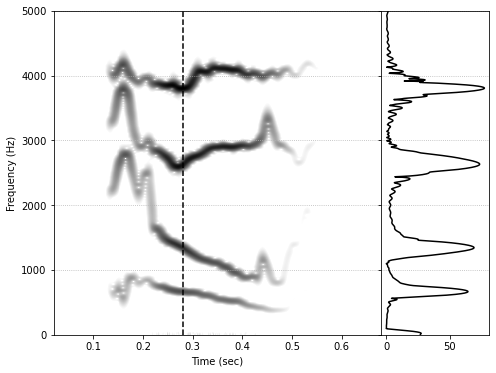

In [4]:
wav,fs = sine_synth(formant_data)
write("example.wav", fs, wav.astype(np.int16))

(freqs,ts,Sxx) = sgram("example.wav", tf=5000, band='nb', slice_time=0.28) 

Audio(wav,rate=fs) 


## What the original sounded like



Resampling from 44100 to 10000


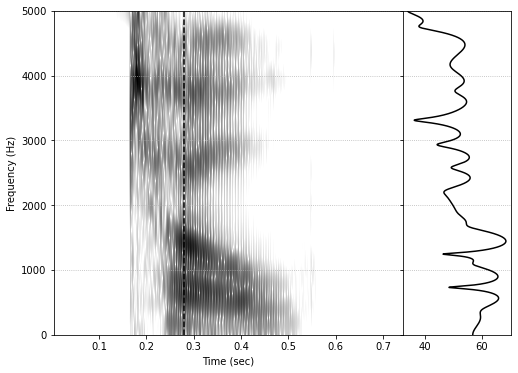

In [7]:
(freqs,ts,Sxx) = sgram("toe_AP.wav", tf=5000, band='wb', slice_time=0.28) 

Audio("toe_AP.wav",rate=fs) 
